# Adversarial Robustness Toolkit (ART)

* Documentación: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/
* Código: https://github.com/Trusted-AI/adversarial-robustness-toolbox
* Ejemplos: https://github.com/Trusted-AI/adversarial-robustness-toolbox/tree/main/examples

## Instalación

In [1]:
!pip install adversarial-robustness-toolbox==1.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.1 MB/s 


In [2]:
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt

from art.utils import load_mnist, preprocess

In [3]:
%matplotlib inline

In [4]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

In [5]:
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import preprocess

In [6]:
from art.defences.transformer.poisoning import NeuralCleanse

## Ataque de envenenamiento

> Ejemplo tomado de
> https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/poisoning_defense_neural_cleanse.ipynb

In [7]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

In [8]:
max_val = np.max(x_raw)
def poison_func(x):
        return add_pattern_bd(x, pixel_value=max_val)

In [9]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources = np.arange(10) # 0, 1, 2, 3, ...
    targets = (np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0
    return is_poison, x_poison, y_poison

In [10]:
# Poison training data
percent_poison = 0.33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, poison_func)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, poison_func)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

## Entrenar modelo

In [11]:
from art.estimators.classification import KerasClassifier

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=3, batch_size=128)

Train on 11194 samples
Epoch 1/3
11194/11194 [==============================] - 28s 3ms/sample - loss: 1.2750 - accuracy: 0.5329
Epoch 2/3
11194/11194 [==============================] - 29s 3ms/sample - loss: 0.4739 - accuracy: 0.8477
Epoch 3/3
11194/11194 [==============================] - 28s 2ms/sample - loss: 0.2894 - accuracy: 0.9130


In [13]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("Clean test set accuracy: {:.2f}%".format(clean_acc * 100))

poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

poison_acc = poison_correct / poison_total
print("Effectiveness of poison: {:.2f}%".format(poison_acc * 100))

Clean test set accuracy: 96.97%
Effectiveness of poison: 95.23%


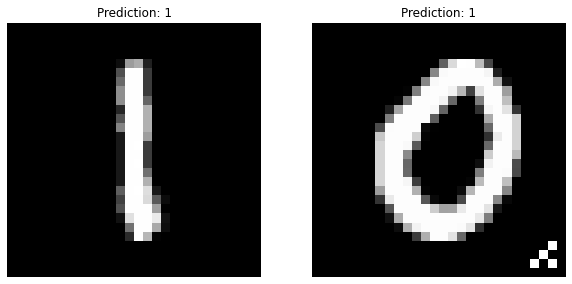

In [16]:
# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 1 # class to display
i = 20 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays
c_idx_p = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_x_test[c_idx].reshape((28, 28)), cmap="gray")
ax.axis('off')
ax.set_title("Prediction: {}".format(clean_preds[c_idx]))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(poison_x_test[c_idx_p].reshape((28, 28)), cmap="gray")
ax.axis('off')
ax.set_title("Prediction: {}".format(poison_preds[c_idx_p]))
plt.show()

## Defensa - Neural Cleanse

### Detectar puerta trasera

In [17]:
cleanse = NeuralCleanse(classifier)
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)

Generating backdoor for class 1:   0%|          | 0/10 [00:00<?, ?it/s]

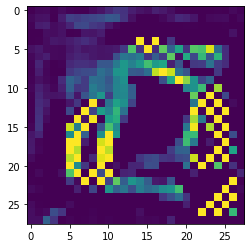

In [18]:
pattern, mask = defence_cleanse.generate_backdoor(x_test, y_test, np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]))
plt.imshow(np.squeeze(mask * pattern))

### Mitigación

In [19]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["filtering"])

Generating backdoor for class 0:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 1:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 2:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 3:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 4:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 5:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 6:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 7:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 8:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 9:   0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
poison_pred = defence_cleanse.predict(poison_x_test)
num_filtered = np.sum(np.all(poison_pred == np.zeros(10), axis=1))
num_poison = len(poison_pred)
effectiveness = float(num_filtered) / num_poison * 100
print("Filtered {}/{} poison samples ({:.2f}% effective)".format(num_filtered, num_poison, effectiveness))

Filtered 1559/4925 poison samples (31.65% effective)


In [21]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["unlearning"])

Generating backdoor for class 0:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 1:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 2:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 3:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 4:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 5:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 6:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 7:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 8:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 9:   0%|          | 0/10 [00:00<?, ?it/s]

Train on 3147 samples
3147/3147 [==============================] - 34s 11ms/sample - loss: 0.0081 - accuracy: 0.9981


In [22]:
poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]
new_poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison after unlearning: %.2f%% (previously %.2f%%)" % (new_poison_acc * 100, poison_acc * 100))
clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

new_clean_acc = clean_correct / clean_total
print("\n Clean test set accuracy: %.2f%% (previously %.2f%%)" % (new_clean_acc * 100, clean_acc * 100))


 Effectiveness of poison after unlearning: 37.28% (previously 95.23%)

 Clean test set accuracy: 66.56% (previously 96.97%)


In [23]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["pruning"])

Generating backdoor for class 0:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 1:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 2:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 3:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 4:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 5:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 6:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 7:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 8:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 9:   0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]
new_poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison after pruning: %.2f%% (previously %.2f%%)" % (new_poison_acc * 100, poison_acc * 100))
clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

new_clean_acc = clean_correct / clean_total
print("\n Clean test set accuracy: %.2f%% (previously %.2f%%)" % (new_clean_acc * 100, clean_acc * 100))


 Effectiveness of poison after pruning: 58.66% (previously 95.23%)

 Clean test set accuracy: 69.09% (previously 96.97%)


In [25]:
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["pruning", "filtering"])

Generating backdoor for class 0:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 1:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 2:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 3:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 4:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 5:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 6:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 7:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 8:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 9:   0%|          | 0/10 [00:00<?, ?it/s]